In [1]:
import sys
# !{sys.executable} -m pip install shap
import lightgbm as lgb
import xgboost
import shap
from xgboost import XGBRegressor
from collections import Counter

from tqdm.notebook import trange, tqdm
from time import sleep, perf_counter

import os
from glob import glob
import pandas as pd
import numpy as np
import networkx as nx
from scipy.spatial import distance_matrix

# Scikit-learn
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Torch
import torch
print(torch.__version__,torch.__path__)
import torch.nn as nn

# Reps
from alchemical_cms import genpaddedCMs
from dscribe.descriptors import SOAP
from dscribe.kernels import REMatchKernel
from mendeleev.fetch import fetch_table
from ase.io import read
from Element_PI import VariancePersist
from Element_PI import VariancePersistv1

from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, MACCSkeys
from openbabel import openbabel as ob
from openbabel import pybel

from xyz2graph import MolGraph, to_networkx_graph, to_plotly_figure
from plotly.offline import offline
#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200


2.1.0 ['/Users/voglab04/miniconda3/envs/molecular_representation/lib/python3.8/site-packages/torch']
Number of monomers is equivalent to monomers+CO2: True
Using the intersection of the sets of length: 0

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [2]:
df=pd.read_excel('site_data.xlsx',index_col=0)
sitelist=['A_carboxy', 'A_amine', 'B_carboxy', 'B_amine', 'A_link','B_link', 'A_side', 'B_side']
inter_df=df[sitelist].dropna()
# inter_df[inter_df!=0]=1

In [3]:


y=pd.read_excel('400_dipeptides_interaction_energy.xlsx',usecols=[1,2],index_col=0)
y['keypair']=['_'.join(i.split('_')[:3]) for i in y.index]
pairs=pd.DataFrame([(i[0].split(":")[0],i[0].split(":")[1].replace(" ","").replace('acid','')) for i in pd.read_excel('400_dipeptides_interaction_energy.xlsx', 'Sheet2',header=None).values]).set_index(0)


# Find set of files
monomerfiles={}        
co2files={}
for k,v in pairs.to_dict()[1].items():
    try:
        path=glob(f'./dipeptides_co2_coordinates/{k}_*.xyz')[0]
        monpath=f'./dipeptides_coordinates/{k}.xyz'
        if os.path.exists(path) and os.path.exists(monpath):
            co2files[v]=path    
            monomerfiles[v]=monpath
    except:
        print(k)
        
# Name check
co2check=['_'.join(i.split('/')[-2].split('_')[:3]) for i in co2files.values()]
moncheck=['_'.join(i.split('/')[-2].split('_')[:4]) for i in monomerfiles.values()]

In [4]:
# pixelsx = 150 # Don't make too large 150
# pixelsy = 150 # 150
pixelsx = 20 # Don't make too large 150
pixelsy = pixelsx # 150
spread = 0.06
Max = 2.5 # 2.5
X=np.zeros((len(monomerfiles),pixelsx**2))
for i,(k,v) in enumerate(monomerfiles.items()):
     X[i,:] = VariancePersistv1(v, pixelx=pixelsx, pixely=pixelsy,myspread=spread, myspecs={"maxBD": Max, "minBD":  -0.1}, showplot=False)
    

In [5]:
VariancePersist

<function Element_PI.VariancePersist(Filename, pixelx=100, pixely=100, myspread=2, myspecs={'maxBD': 2, 'minBD': 0}, showplot=True)>

In [6]:
AAs=sorted(set([i[0].split('-')[0].replace('acid','') for i in pairs.values]))

In [7]:
noncarboyx=inter_df[(inter_df[['A_carboxy','B_carboxy']]==0).all(axis=1)]

In [8]:
noncarboyx

,A_carboxy,A_amine,B_carboxy,B_amine,A_link,B_link,A_side,B_side
Alanine-Lysine,0,0,0,1,0,0,0,2
Arginine-Aspartic,0,0,0,0,0,0,0,3
Arginine-Cysteine,0,0,0,0,0,0,3,0
Arginine-Lysine,0,0,0,0,0,0,3,0
Arginine-Phenylalanine,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...
Tryptophan-Proline,0,0,0,0,0,0,3,0
Tryptophan-Tryptophan,0,0,0,0,0,0,0,3
Tyrosine-Arginine,0,0,0,2,0,0,0,1
Tyrosine-Lysine,0,1,0,0,0,0,0,2


In [9]:

co2dipepgraphs={}
co2mgs={}
for k,v in co2files.items():
    # Create the MolGraph object
    mg = MolGraph()

    # Read the data from the .xyz file
    mg.read_xyz(v)
    co2mgs[k]=mg
    # Convert the molecular graph to the NetworkX graph
    G = to_networkx_graph(mg)
    co2dipepgraphs[k]=G
    
dipepgraphs={}    
mgs={}
for k,v in monomerfiles.items():
    # Create the MolGraph object
    mg = MolGraph()

    # Read the data from the .xyz file
    mg.read_xyz(v)
    mgs[k]=mg
    # Convert the molecular graph to the NetworkX graph
    G = to_networkx_graph(mg)
    dipepgraphs[k]=G    


In [10]:
# FLAG!
# df.loc['Asparagine-Alanine']
# fig = to_plotly_figure(co2mgs['Asparagine-Alanine'])
# offline.plot(fig)

# FLAG THIS ONE!!
# fig = to_plotly_figure(co2mgs['Alanine-Lysine'])
# offline.plot(fig)

In [11]:
for k,v in pairs.to_dict()[1].items():
    names=v.split('-')
    for j in names:
        if 'acid' in j:
            print(names)

In [12]:
AAs

['Alanine',
 'Arginine',
 'Asparagine',
 'Aspartic',
 'Cysteine',
 'Glutamic',
 'Glutamine',
 'Glycine',
 'Histidine',
 'Isoleucine',
 'Leucine',
 'Lysine',
 'Methionine',
 'Phenylalanine',
 'Proline',
 'Serine',
 'Threonine',
 'Tryptophan',
 'Tyrosine',
 'Valine']

In [13]:
tsne = TSNE(n_components=2, verbose=1, perplexity=399, n_iter=500)
tsne_results = tsne.fit_transform(X)
pcadf=pd.DataFrame(columns=['tsne-2d-one','tsne-2d-two'])
pcadf['tsne-2d-one'] = tsne_results[:,0]
pcadf['tsne-2d-two'] = tsne_results[:,1]
pcadf.index=df.index
pcadf[df.columns]=df[df.columns]

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue='B_side',
#     palette=sns.color_palette("hls", 8),
#     data=pcadf,
#     legend="full"
# )

/Users/voglab04/miniconda3/envs/molecular_representation/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/voglab04/miniconda3/envs/molecular_representation/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 399 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 91.080713
[t-SNE] KL divergence after 250 iterations with early exaggeration: 37.676037
[t-SNE] KL divergence after 500 iterations: 0.000056


In [14]:
pcadf

,tsne-2d-one,tsne-2d-two,A_carboxy,A_amine,B_carboxy,B_amine,A_link,B_link,A_side,B_side,Interaction_Energy,label
Alanine-Alanine,0.145537,-0.235399,0,0,2,1,0,0,0,0,-4.032639,AA_AA_1
Alanine-Arginine,0.114374,-0.212366,0,0,1,1,0,0,0,1,-5.392723,AA_AA_2
Alanine-Asparagine,0.146532,-0.232736,2,0,0,0,0,0,0,1,-5.716392,AA_AA_3
Alanine-Aspartic,0.146199,-0.240078,2,0,0,0,0,1,0,0,-5.247079,AA_AA_4
Alanine-Cysteine,0.154174,-0.240950,2,0,0,0,0,0,0,1,-4.872244,AA_AA_5
...,...,...,...,...,...,...,...,...,...,...,...,...
Valine-Serine,0.125185,-0.208779,0,1,1,0,1,0,0,0,-5.861945,AA_AA_396
Valine-Threonine,0.110980,-0.201978,1,0,0,0,0,0,1,1,-4.461757,AA_AA_397
Valine-Tryptophan,0.052036,-0.222254,2,1,0,0,0,0,0,0,-5.625054,AA_AA_398
Valine-Tyrosine,0.065783,-0.211377,1,1,0,0,0,0,0,1,-4.655518,AA_AA_399


Explained variation per principal component: [0.49330245 0.37875061]
0.8720530557324828


/var/folders/df/wnp2kps17hx3h900x0l75f440000gn/T/ipykernel_36230/1896195632.py:10: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



<AxesSubplot: xlabel='pca-one', ylabel='pca-two'>

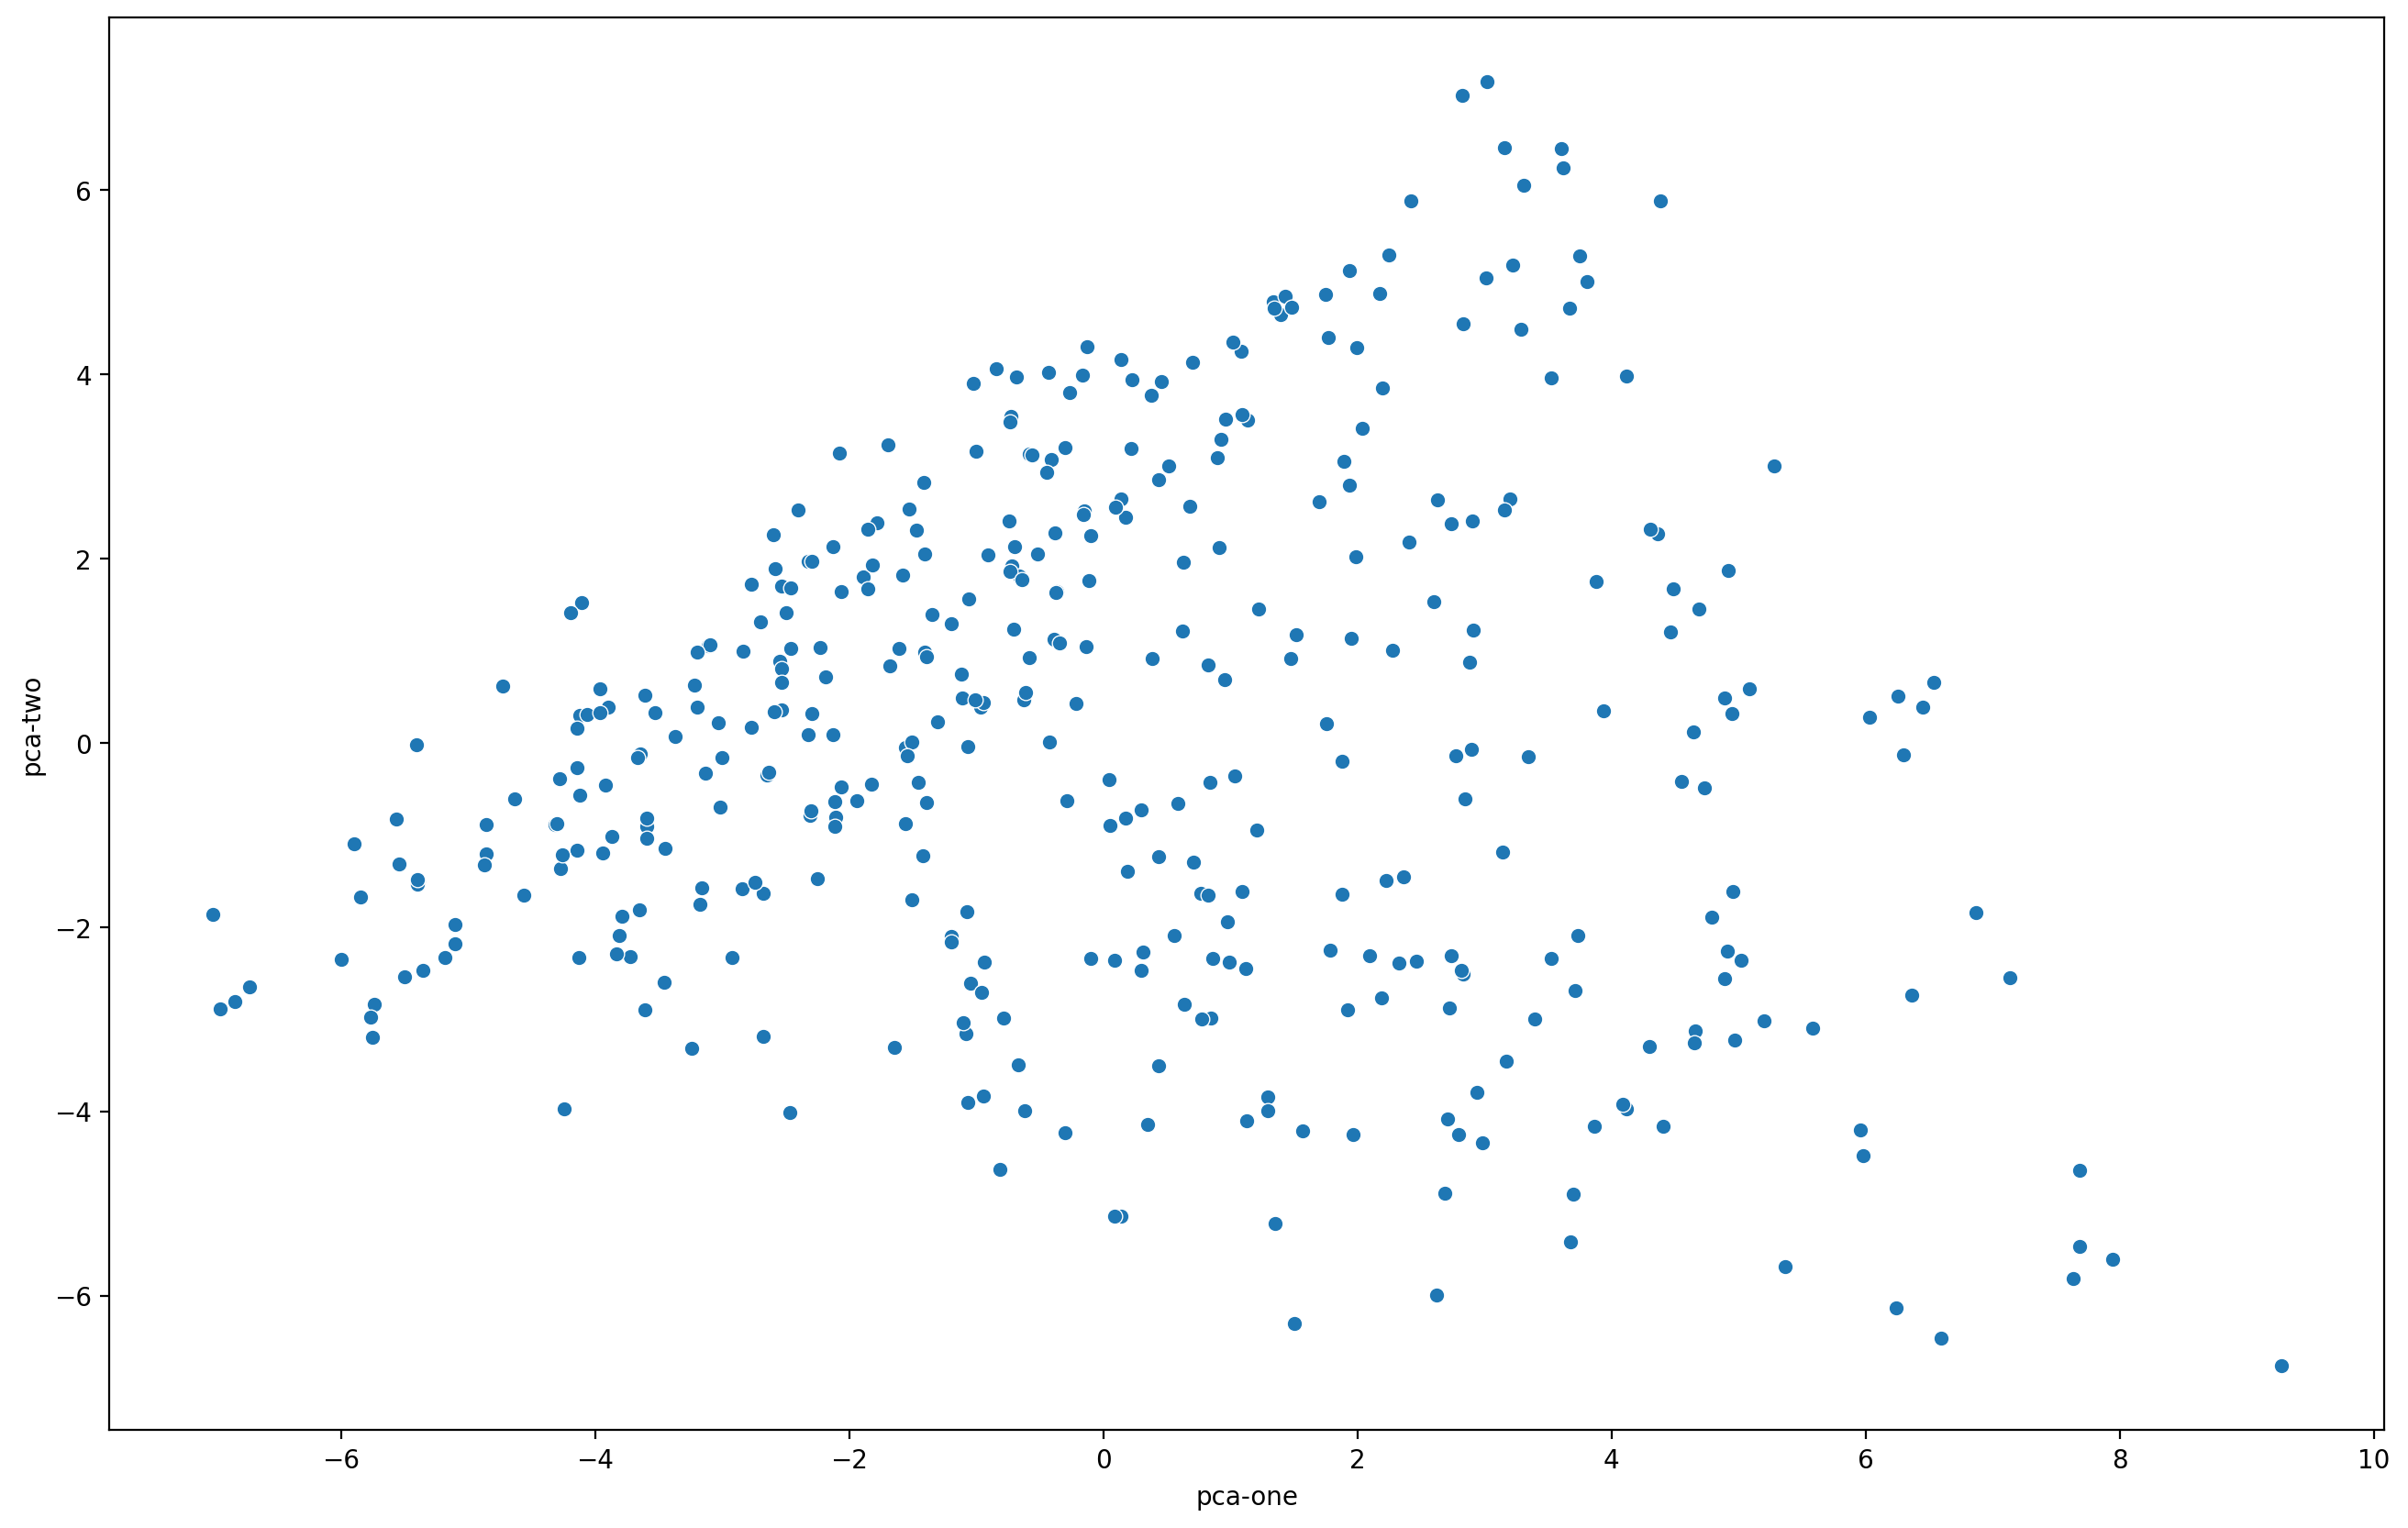

In [15]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

pcadf['pca-one'] = pca_result[:,0]
pcadf['pca-two'] = pca_result[:,1] 
# pcadf['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print(sum(pca.explained_variance_ratio_))
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    # hue='A_side',
    palette=sns.color_palette("hls", 8),
    data=pcadf,
    legend="full"
)

# sns.scatterplot(
#     x="pca-one", y="pca-three",
#     hue='Interaction_Energy',
#     palette=sns.color_palette("hls", 8),
#     data=pcadf,
#     legend="full"
# )


In [153]:
sorted_IE={}
all_energies=pd.DataFrame(columns=AAs,index=AAs)
IE_df=pd.DataFrame(columns=AAs,index=AAs)
glygly_df=pd.DataFrame(columns=AAs,index=AAs)
for A in AAs:
    sorted_IE[A]={B:df['Interaction_Energy'].to_dict()['-'.join((A,B))] for B in AAs}
    for B in AAs:
        IE_df[A].loc[B]=df['Interaction_Energy'].to_dict()['-'.join((A,B))]-df['Interaction_Energy'].to_dict()['-'.join((A,A))]
        glygly_df[A].loc[B]=df['Interaction_Energy'].to_dict()['-'.join((A,B))]-df['Interaction_Energy'].to_dict()['-'.join(('Glycine','Glycine'))]
        all_energies[A].loc[B]=df['Interaction_Energy'].to_dict()['-'.join((A,B))]

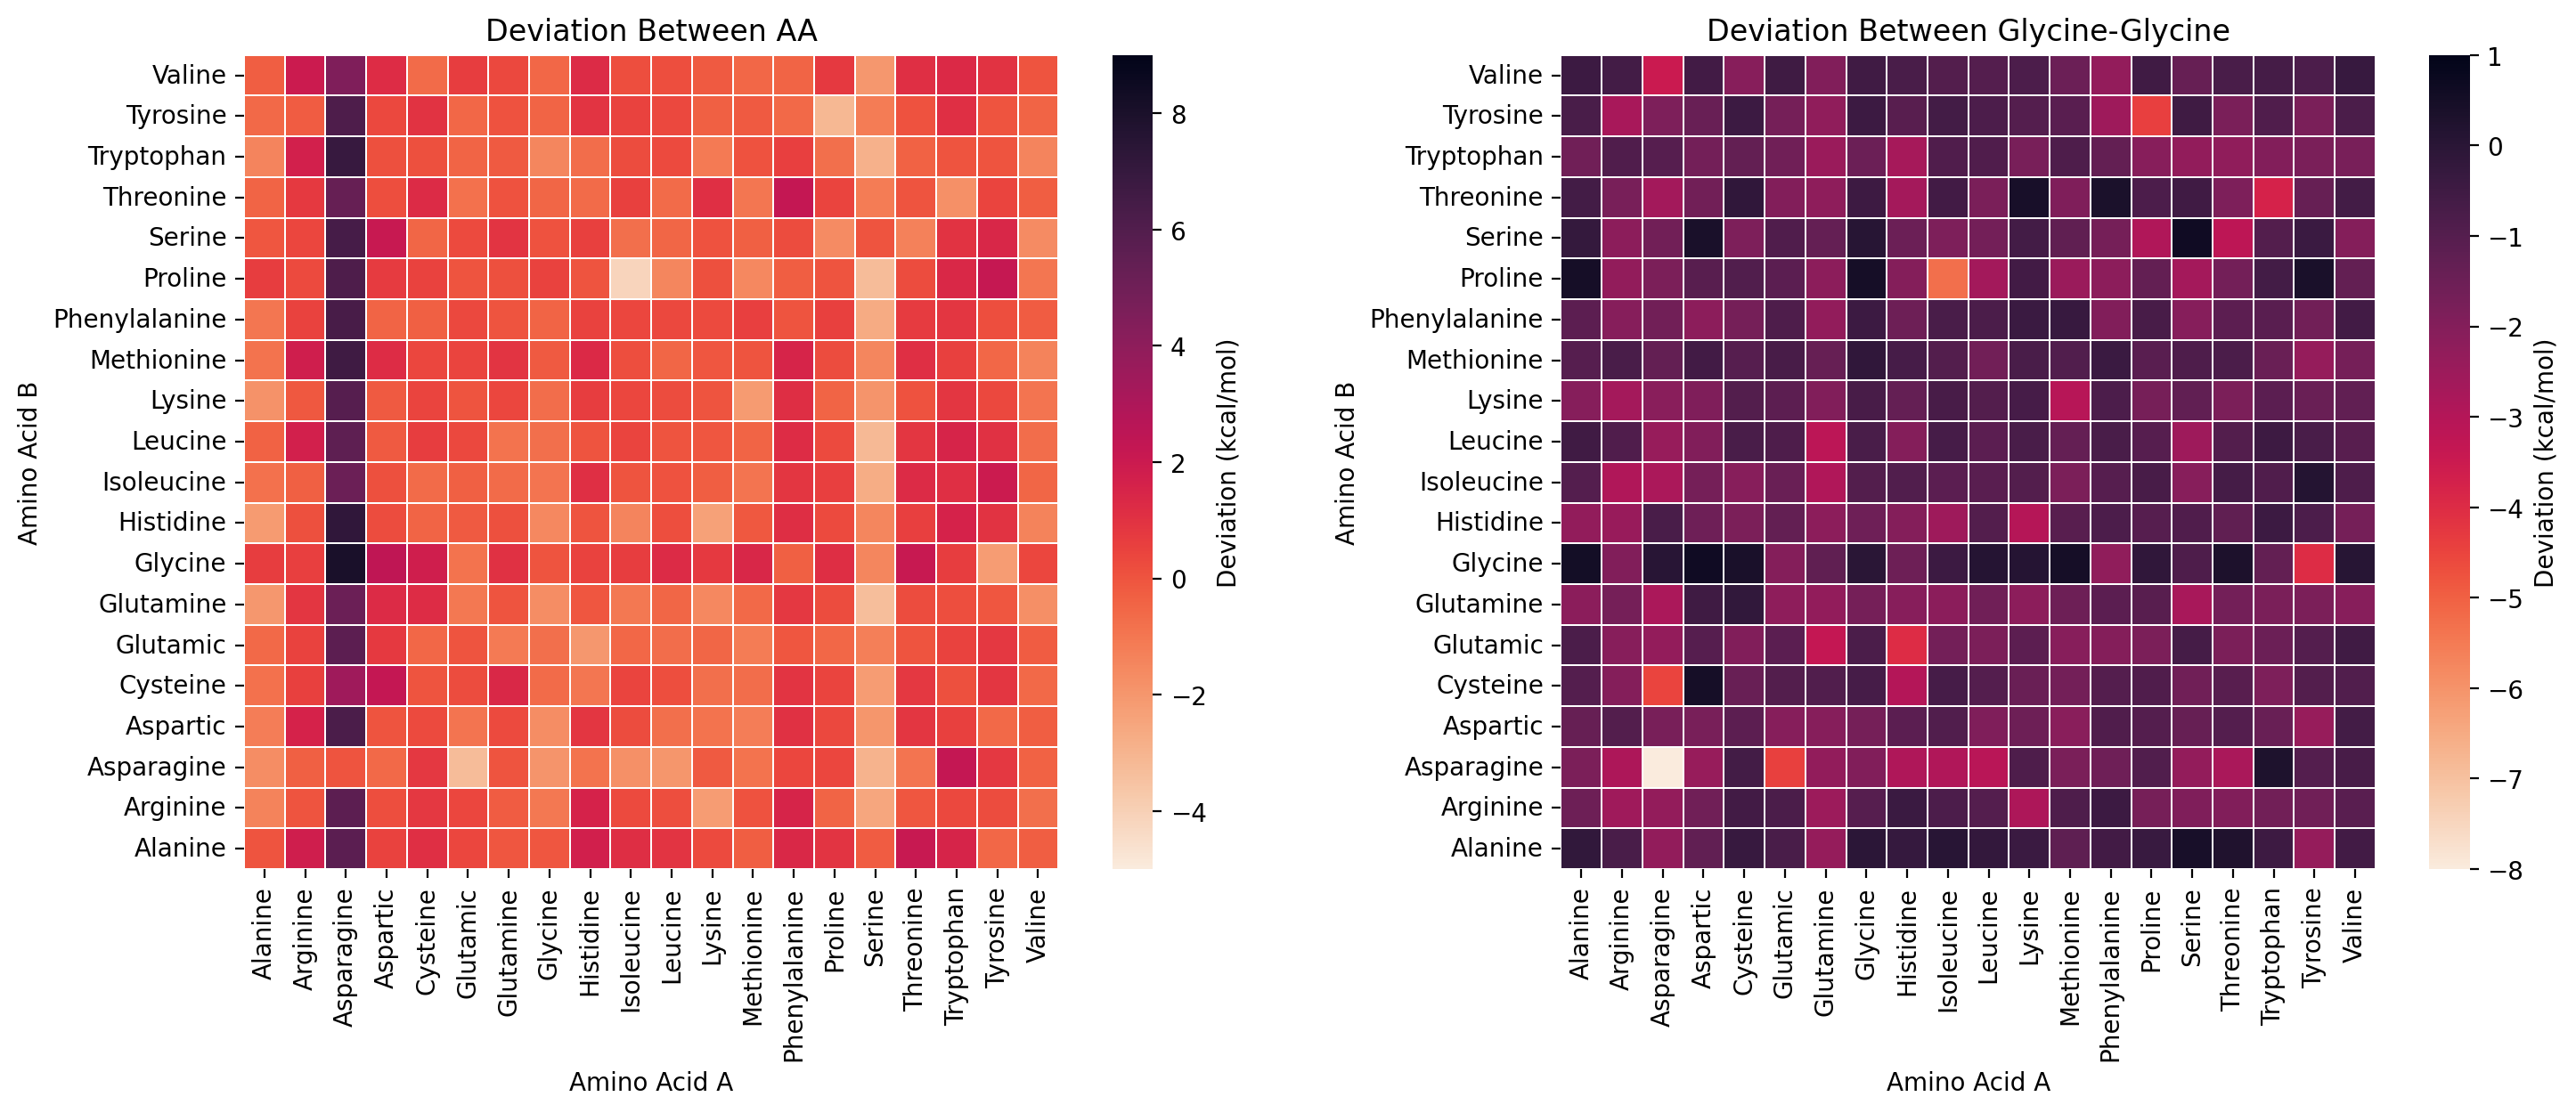

In [17]:
from matplotlib.colors import LinearSegmentedColormap

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,6))
cmap = sns.cm.rocket_r
# cmap = LinearSegmentedColormap.from_list('', np.vstack([sns.color_palette('rocket'),sns.color_palette('rocket_r')]))
sns.heatmap(data=IE_df.astype(float),ax=ax1,cmap=cmap, linewidth=.01,cbar_kws={'label': 'Deviation (kcal/mol)'}, vmin=-5, vmax=9,square=True)
ax1.set_title('Deviation Between AA')
ax1.set_xlabel('Amino Acid A')
ax1.set_ylabel('Amino Acid B')
ax1.invert_yaxis()

# cmap = LinearSegmentedColormap.from_list('', np.vstack([sns.color_palette('rocket',8),sns.color_palette('rocket_r',3)]))
sns.heatmap(data=glygly_df.astype(float),ax=ax2,cmap=cmap, linewidth=.01,cbar_kws={'label': 'Deviation (kcal/mol)'}, vmin=-8, vmax=1,square=True)
ax2.set_title('Deviation Between Glycine-Glycine')
ax2.set_xlabel('Amino Acid A')
ax2.set_ylabel('Amino Acid B')
ax2.invert_yaxis()
plt.tight_layout()
plt.savefig('deviations.png',dpi=300,bbox_inches='tight')
plt.show()

In [46]:
site_df=df[sorted(sitelist)+['Interaction_Energy']].sort_values(by='Interaction_Energy')

In [47]:
site_df[site_df==0]=np.nan

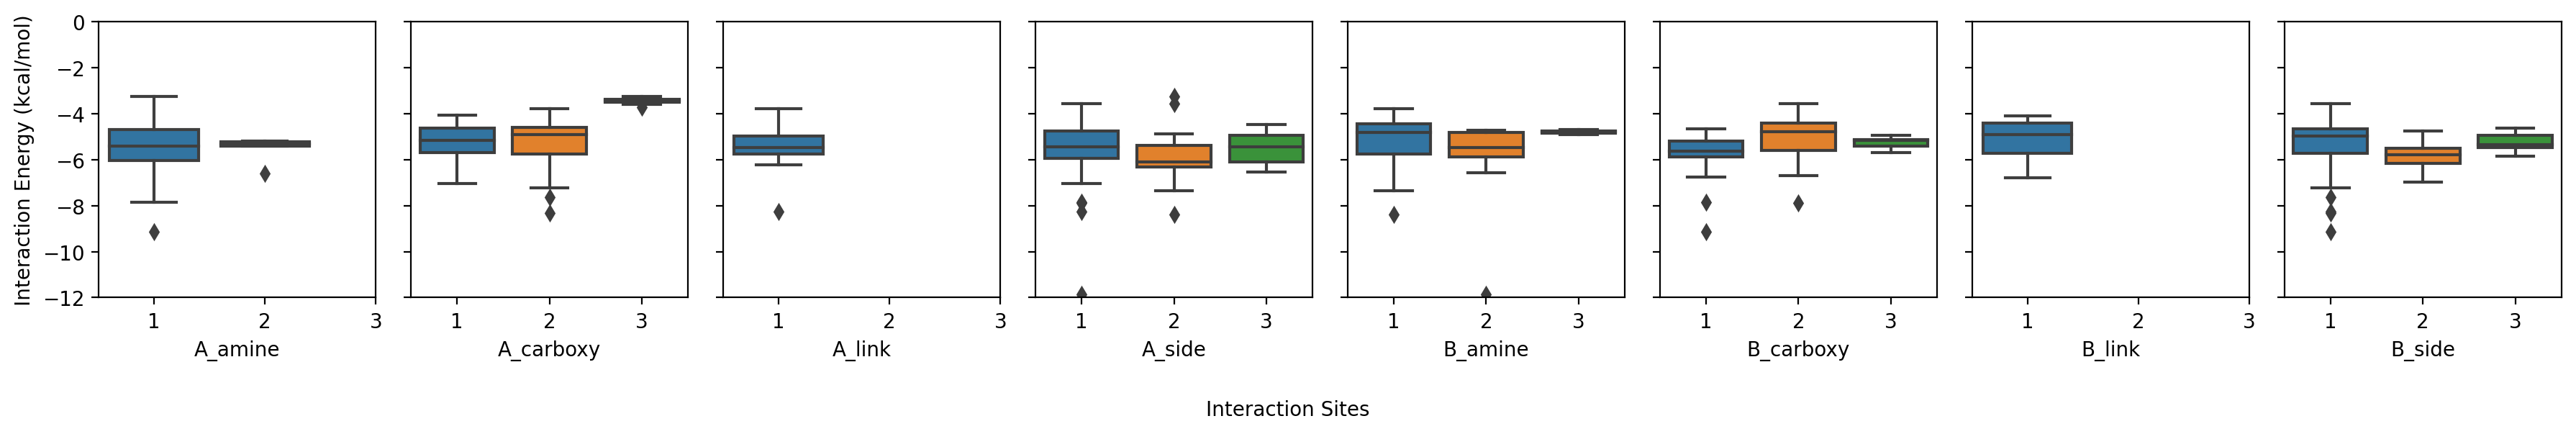

In [52]:

fig,ax=plt.subplots(1,len(sitelist),figsize=(len(sitelist)*2.25,int(len(sitelist)*0.45)),sharey=True)
for idx,i in enumerate(sorted(sitelist)):
    sns.boxplot(data=site_df,x=i,y='Interaction_Energy',ax=ax[idx])
    ax[idx].set_xticks([0,1,2])
    ax[idx].set_xticklabels([1,2,3])
    ax[idx].set_ylim(-12,0)
    
    if idx==0:
        ax[idx].set_ylabel('Interaction Energy (kcal/mol)')
    else:
        ax[idx].set_ylabel('')
    
fig.supxlabel('Interaction Sites',fontsize=10)
plt.tight_layout()
plt.savefig('boxplot.png',dpi=300,bbox_inches='tight')
plt.show()

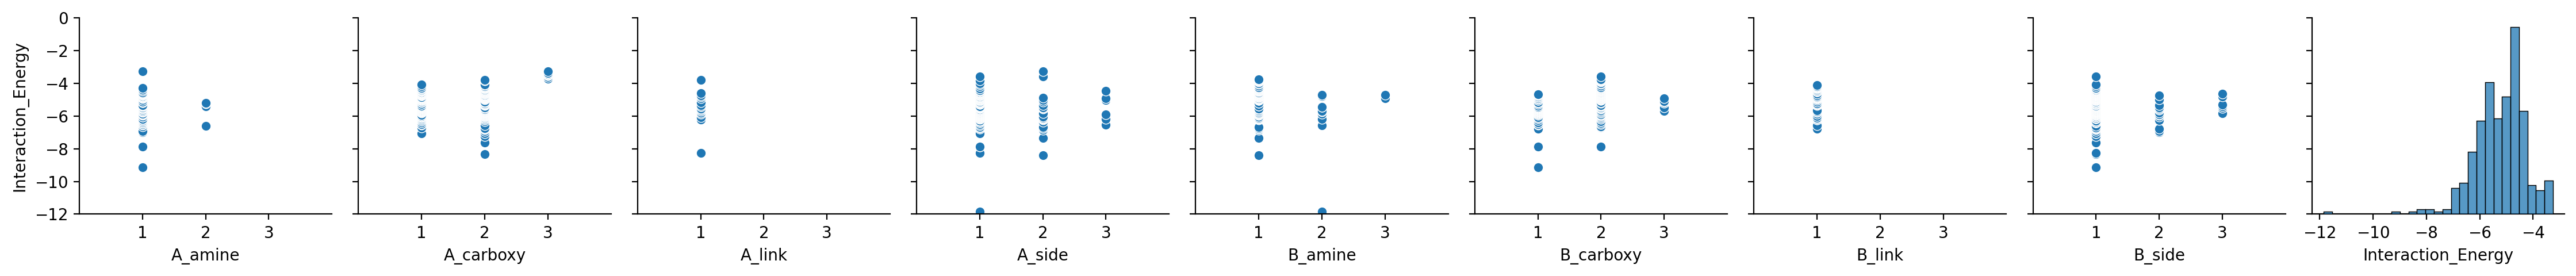

In [51]:
g=sns.pairplot(data=site_df,y_vars=['Interaction_Energy'])

for i in range(len(sitelist)):
    ax=g.axes[0,i]
    ax.set_xticks([1,2,3])
    ax.set_xticklabels([1,2,3])
    ax.set_xlim(0,4)
    ax.set_ylim(-12,0)
plt.tight_layout()
plt.savefig('pairplot.png',dpi=300,bbox_inches='tight')
plt.show()

In [75]:
SerDF=site_df.loc[[i for i in site_df.index if 'Serine-' in i]]

SerList=[]
SerDict={}
for i in SerDF.index:
    subdf=SerDF[sitelist].loc[i]
    SerList.append(['/'.join(subdf.dropna().index),SerDF['Interaction_Energy'].loc[i]])
    

for i in set(np.array(SerList)[:,0]):
    SerDict[i]=[IE for nam,IE in SerList if nam==i]    

SerInt=pd.DataFrame.from_dict(SerDict,orient='index').T        


<AxesSubplot: ylabel='Density'>

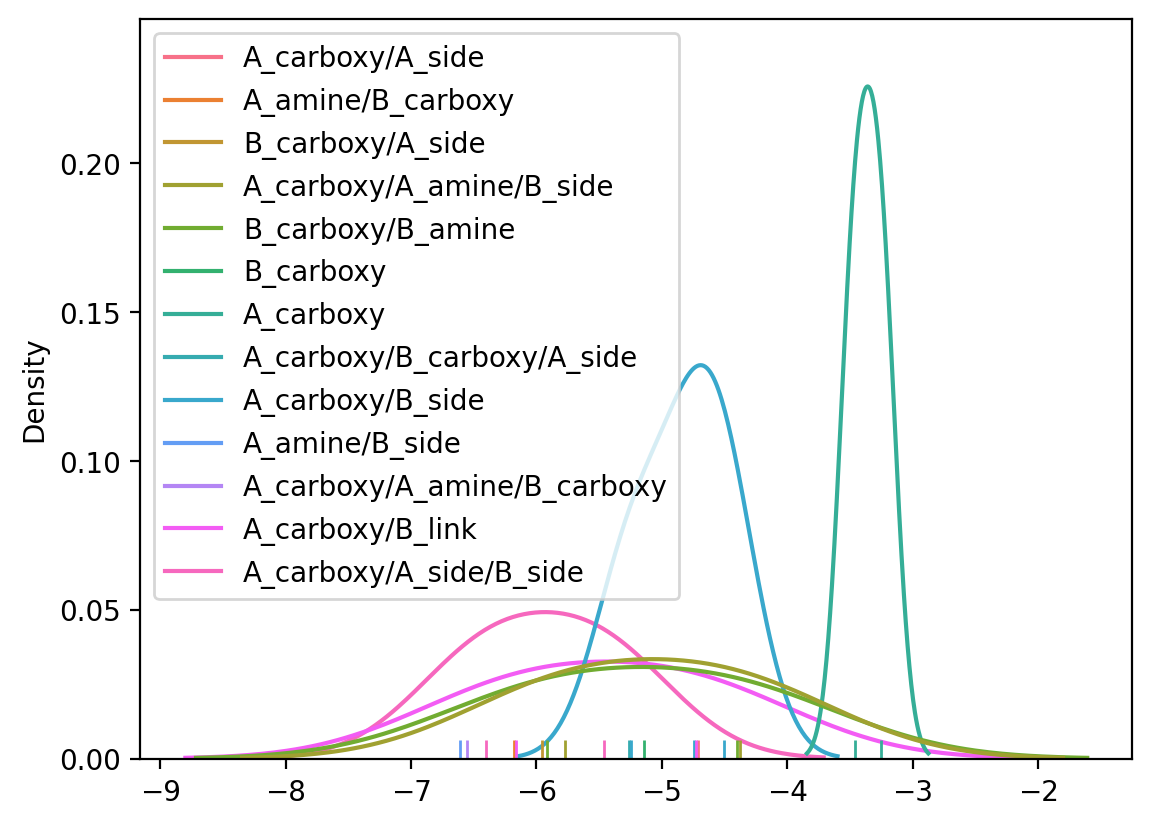

In [86]:
# sns.kdeplot(data=SerDF,x='Interaction_Energy')
# sns.kdeplot(data=SerInt.T[(SerInt.count()>1)].T)
# sns.rugplot(data=SerInt.T[(SerInt.count()>1)].T)


sns.kdeplot(data=SerInt,warn_singular=False)
sns.rugplot(data=SerInt)


In [81]:
AspDF=site_df.loc[[i for i in site_df.index if 'Asparagine-' in i]]

AspList=[]
AspDict={}
for i in AspDF.index:
    subdf=AspDF[sitelist].loc[i]
    AspList.append(['/'.join(subdf.dropna().index),AspDF['Interaction_Energy'].loc[i]])
    

for i in set(np.array(AspList)[:,0]):
    AspDict[i]=[IE for nam,IE in AspList if nam==i]    
    
AspInt=pd.DataFrame.from_dict(AspDict,orient='index').T   



<AxesSubplot: ylabel='Density'>

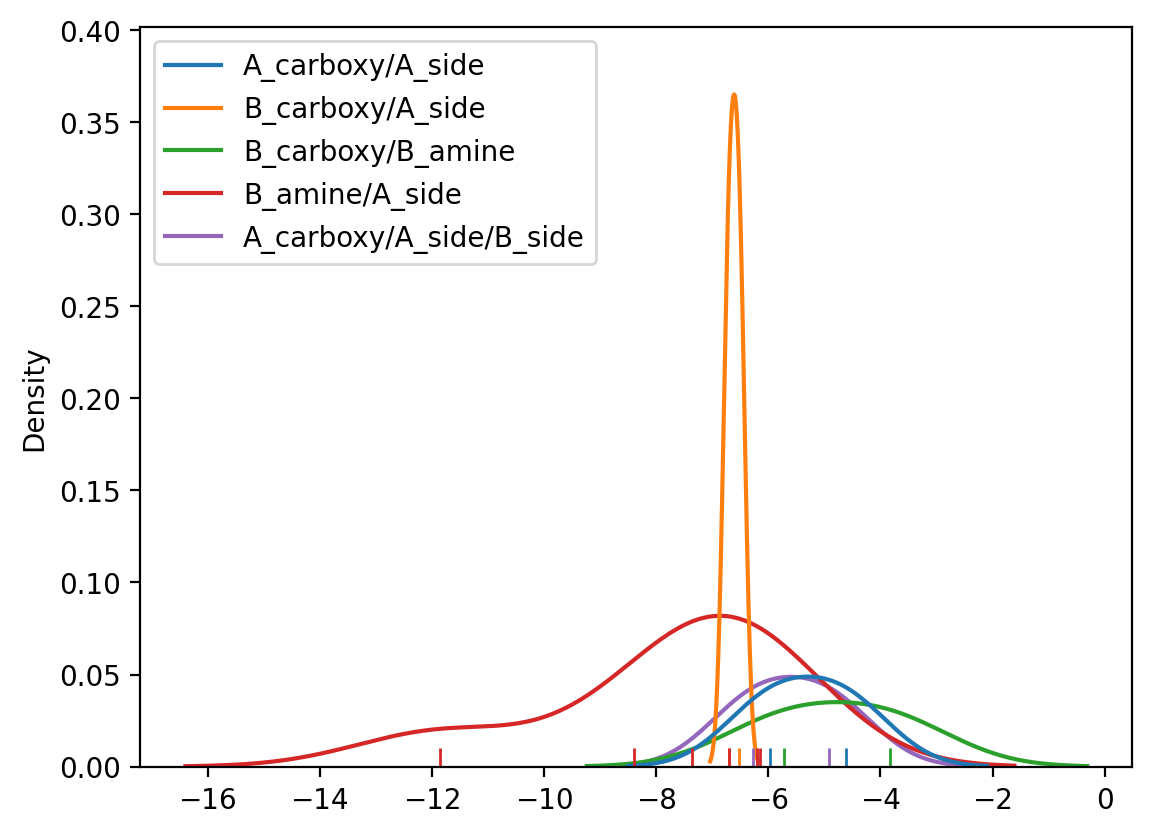

In [87]:
# sns.kdeplot(data=AspDF,x='Interaction_Energy')
sns.kdeplot(data=AspInt.T[(AspInt.count()>1)].T)
sns.rugplot(data=AspInt.T[(AspInt.count()>1)].T)


# sns.kdeplot(data=SerInt,warn_singular=False)
# sns.rugplot(data=SerInt)


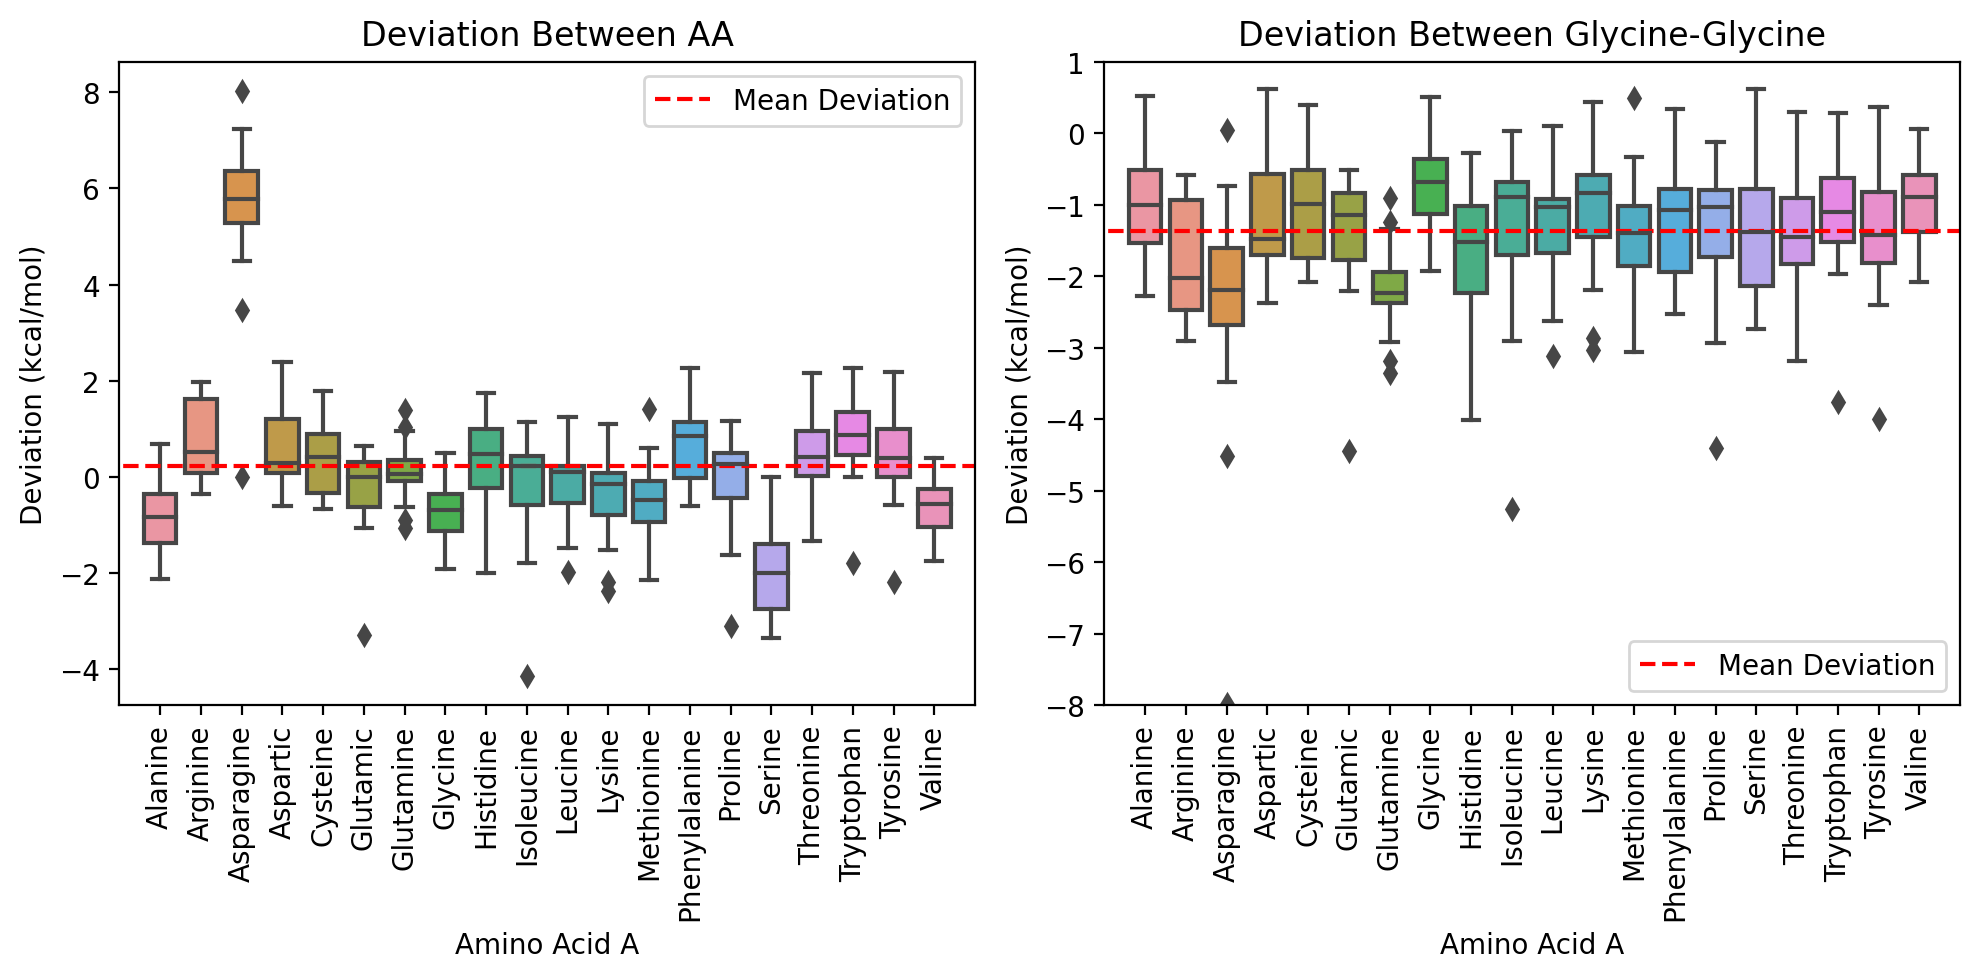

In [74]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
sns.boxplot(data=IE_df.astype(float),ax=ax1)
ax1.hlines(np.mean(IE_df.values.flatten()),-2,20,color='red',linestyles='--',label='Mean Deviation')
ax1.legend()
ax1.set_xlim(-1,20)
ax2.set_ylim(-5,9)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90, ha="center")
ax1.set_title('Deviation Between AA')
ax1.set_xlabel('Amino Acid A')
ax1.set_ylabel('Deviation (kcal/mol)')

sns.boxplot(data=glygly_df.astype(float),ax=ax2)
ax2.hlines(np.mean(glygly_df.values.flatten()),-2,20,color='red',linestyles='--',label='Mean Deviation')
ax2.legend()
ax2.set_xlim(-1,20)
ax2.set_ylim(-8,1)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90, ha="center")
ax2.set_title('Deviation Between Glycine-Glycine')
ax2.set_xlabel('Amino Acid A')
ax2.set_ylabel('Deviation (kcal/mol)')
plt.tight_layout()
plt.savefig('deviation_boxplots.png',dpi=300,bbox_inches='tight')
plt.tight_layout()

In [94]:
glygly_df.astype(float).describe().drop('count')

,Alanine,Arginine,Asparagine,Aspartic,Cysteine,Glutamic,Glutamine,Glycine,Histidine,Isoleucine,Leucine,Lysine,Methionine,Phenylalanine,Proline,Serine,Threonine,Tryptophan,Tyrosine,Valine
mean,-0.970724,-1.844880,-2.370265,-1.159825,-1.041831,-1.420501,-2.163026,-0.732103,-1.722782,-1.320945,-1.288086,-1.056699,-1.414493,-1.258690,-1.310041,-1.370556,-1.388552,-1.194924,-1.388166,-1.013041
std,0.798698,0.781449,1.644858,0.876907,0.725469,0.874819,0.614865,0.666728,0.979273,1.185639,0.749060,0.880179,0.775438,0.772517,0.973637,0.969775,0.877608,0.835294,0.984711,0.583286
min,-2.281057,-2.903062,-7.980883,-2.382163,-2.080381,-4.441183,-3.356886,-1.923020,-4.017265,-5.257833,-3.111643,-3.037602,-3.064986,-2.526149,-4.401130,-2.736727,-3.190367,-3.764817,-3.998273,-2.077662
25%,-1.535586,-2.467315,-2.689169,-1.698473,-1.740026,-1.768211,-2.372666,-1.130865,-2.233844,-1.699813,-1.677482,-1.457527,-1.855115,-1.944518,-1.731259,-2.137486,-1.834276,-1.523862,-1.818186,-1.383676
50%,-0.998780,-2.030057,-2.193256,-1.477692,-0.992758,-1.151774,-2.239322,-0.688530,-1.528399,-0.898006,-1.035197,-0.831213,-1.401166,-1.079720,-1.029896,-1.381103,-1.450641,-1.100302,-1.423649,-0.888771
75%,-0.508426,-0.932681,-1.610788,-0.571581,-0.521786,-0.835956,-1.939103,-0.360266,-1.019983,-0.677129,-0.920463,-0.584462,-1.015846,-0.779742,-0.797531,-0.787318,-0.907653,-0.625906,-0.821617,-0.585930
max,0.512902,-0.583767,0.048928,0.613789,0.391658,-0.510703,-0.905615,0.502803,-0.271144,0.030953,0.098075,0.437014,0.497746,0.340913,-0.128168,0.616150,0.302144,0.288901,0.368246,0.061021


In [152]:
IE_df

,Alanine,Arginine,Asparagine,Aspartic,Cysteine,Glutamic,Glutamine,Glycine,Histidine,Isoleucine,Leucine,Lysine,Methionine,Phenylalanine,Proline,Serine,Threonine,Tryptophan,Tyrosine,Valine
Alanine,0.0,1.804303,5.700024,0.508134,1.098019,0.392811,-0.047438,-0.041254,1.737793,1.14839,0.936912,0.286895,-0.282426,1.348578,0.940762,-0.206354,2.117222,1.518969,-0.537585,-0.243579
Arginine,-1.360084,0.0,5.657627,0.171775,0.84927,0.367615,-0.202487,-1.011254,1.614062,0.293149,0.149114,-2.189602,0.079408,1.516807,-0.435619,-2.515925,-0.071021,0.344209,0.220775,-0.757924
Asparagine,-1.683753,-0.301017,0.0,-0.612436,0.815518,-3.297021,-0.008757,-1.92302,-0.883764,-1.790577,-1.974387,-0.168834,-0.888242,0.366141,0.36114,-2.924442,-0.937735,2.264375,0.833256,-0.365774
Aspartic,-1.214439,1.601422,6.21974,0.0,0.251408,-0.910276,0.256456,-1.67992,0.898338,0.198821,-0.761724,-0.856752,-1.197823,1.042456,0.320568,-1.989388,0.854593,0.551399,-0.595073,-0.260276
Cysteine,-0.839605,0.53689,3.467286,2.254439,0.0,0.198014,1.3875,-0.675597,-0.986357,0.437893,0.149231,-0.761482,-0.716122,0.938004,0.428709,-2.202383,0.80212,0.114949,0.852696,-0.600396
Glutamic,-0.60284,0.493278,5.65867,0.745376,-0.544737,0.0,-1.063771,-0.760534,-2.008329,-0.524137,-0.698215,-0.496223,-1.139604,-0.071008,-0.550493,-1.251614,0.031106,0.487413,0.835367,-0.19701
Glutamine,-1.99985,0.863484,5.16054,1.277018,1.213146,-1.060343,0.0,-1.705266,-0.074728,-1.036956,-0.461465,-1.516651,-0.600326,0.802341,0.234821,-3.352876,0.202795,0.180133,-0.03378,-1.746534
Glycine,0.673454,0.624029,8.029811,2.383515,1.794763,-0.851894,1.045637,0.0,0.478512,0.682677,1.23533,0.763873,1.420397,-0.314169,1.164523,-1.454085,2.15975,0.666701,-2.188532,0.392149
Histidine,-2.120504,0.112815,7.237367,0.226732,-0.441135,-0.170306,0.109868,-1.539048,0.0,-1.411154,0.172387,-2.365375,-0.12426,1.132681,0.269995,-1.484503,0.608153,1.565468,0.98488,-1.3591
Isoleucine,-0.83685,-0.351135,5.15311,0.095004,-0.656902,-0.312947,-0.630462,-0.939535,1.075823,0.0,0.06039,-0.278819,-0.911555,0.891751,0.595339,-2.70369,1.238624,1.091793,1.965784,-0.514889


In [154]:
unX=all_energies.unstack().reset_index()

In [155]:
for idx,nam in list(enumerate(AAs)):
    unX[unX==nam]=idx

In [180]:
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.colors import ListedColormap
# # axes instance
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


# # plot
# # sc = ax.scatter(unX['level_0'].values, unX['level_1'].values, unX[0].values, s=40,c=unX[0].values, marker='o', cmap=cmap, alpha=1)
# X=Y=range(len(AAs))
# X, Y = np.meshgrid(X, Y)
# sc = ax.plot_surface(X,Y, unX[0].values.reshape(20,20), cmap=sns.cm.rocket_r)
# fig.colorbar(sc, shrink=0.5, aspect=5)

# ax.set_xlabel('Amino Acid A')
# ax.set_xticks(range(len(AAs)))
# ax.set_xticklabels(AAs)
# ax.set_yticks(range(len(AAs)))
# ax.set_yticklabels(AAs)
# ax.set_ylabel('Amino Acid B')
# ax.set_zlabel('Interaction Energy (kcal/mol)')
# plt.tight_layout()
# plt.show()

In [ ]:
# # Create the MolGraph object
# mg = MolGraph()

# # Read the data from the .xyz file
# mg.read_xyz(monomerfiles[0])


# # Convert the molecular graph to the NetworkX graph
# G = to_networkx_graph(mg)

# # G.nodes(data=True),G.edges(data=True)

In [ ]:
# from rdkit.Chem import rdFingerprintGenerator
# mols=[Chem.MolFromSmiles(list(pybel.readfile('xyz',m))[0].write().split('\t')[0]) for m in monomerfiles]
# fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=6)

# # info={}
# # X = np.vstack([fpgen.GetFingerprint(mol) for mol in mols ])

# fps = [MACCSkeys.GenMACCSKeys(x) for x in mols]
# X=np.vstack([f.ToList() for f in fps])
# Y=y.values

# keys=pd.read_excel('MACCS_keys_example.xlsx',index_col='Key').drop(columns=['Unnamed: 0'])

# mol_keys=[idx for idx, i in enumerate(X[0]) if i==1]

# {str(keys.loc[idx].values[0]):i for idx, i in enumerate(np.count_nonzero(X,axis=0)) if i!=0}

In [ ]:

# sns.heatmap([[DataStructs.TanimotoSimilarity(i,j) for i in fps] for j in fps],vmin=0,vmax=1,cmap=sns.cm.rocket_r)
# plt.show()

In [ ]:
# Draw.MolsToGridImage(mols,molsPerRow=10, subImgSize=(300,300))